In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import streamlit as st
import warnings
import sklearn
import xgboost 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
!pip install mlflow
import mlflow
import datetime

warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [12]:
#Data Loading
file_name = 'train.csv'

# Checking if the dataset file exists
if os.path.exists(file_name):
    print(f"Loading data from {file_name}...")
    df = pd.read_csv(file_name)
    df = df.sample(n=10000, random_state=RANDOM_STATE).reset_index(drop=True)
    print("Dataset loaded successfully.")
else:
    print(f"'{file_name}' not found. Generating the dataset for demonstration")
    # Generating data with 20 features and 1000 rows
    n_rows = 1000
    df = pd.DataFrame({
        'Age': np.random.randint(18, 65, n_rows),
        'Gender': np.random.choice(['Male', 'Female'], n_rows),
        'Annual Income': np.random.lognormal(mean=11.5, sigma=0.8, size=n_rows).astype(int),
        'Marital Status': np.random.choice(['Single', 'Married', 'Divorced'], n_rows),
        'Number of Dependents': np.random.randint(0, 5, n_rows),
        'Education Level': np.random.choice(["High School", "Bachelor's", "Master's", "PhD"], n_rows),
        'Occupation': np.random.choice(['Employed', 'Self-Employed', 'Unemployed'], n_rows),
        'Health Score': np.random.lognormal(mean=2, sigma=0.5, size=n_rows).astype(int),
        'Location': np.random.choice(['Urban', 'Suburban', 'Rural'], n_rows),
        'Policy Type': np.random.choice(['Basic', 'Comprehensive', 'Premium'], n_rows),
        'Previous Claims': np.random.randint(0, 3, n_rows),
        'Vehicle Age': np.random.randint(0, 20, n_rows),
        'Credit Score': np.random.randint(300, 850, n_rows),
        'Insurance Duration': np.random.randint(1, 15, n_rows),
        'Premium Amount': np.random.lognormal(mean=9.5, sigma=0.5, size=n_rows).astype(int),
        'Policy Start Date': pd.to_datetime(pd.Series(pd.date_range('2010-01-01', '2022-12-31', n_rows))),
        'Customer Feedback': np.random.choice(['Good service', 'Long waiting time', 'Very satisfied', 'Could be better'], n_rows),
        'Smoking Status': np.random.choice(['Yes', 'No'], n_rows),
        'Exercise Frequency': np.random.choice(['Daily', 'Weekly', 'Monthly', 'Rarely'], n_rows),
        'Property Type': np.random.choice(['House', 'Apartment', 'Condo'], n_rows)
    })
    # Adding some missing values to the synthetic data to simulate conditions
    df.loc[df.sample(frac=0.05, random_state=RANDOM_STATE).index, 'Number of Dependents'] = np.nan
    df.loc[df.sample(frac=0.05, random_state=RANDOM_STATE).index, 'Credit Score'] = np.nan
    df['Premium Amount'] = df['Premium Amount'] + df['Age'] * 10 

print("Dataset Info")
df.info()
print("First 5 Rows")
print(df.head())
print(f"Total rows in dataset: {len(df)}")

'train.csv' not found. Generating the dataset for demonstration
Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Age                   1000 non-null   int32         
 1   Gender                1000 non-null   object        
 2   Annual Income         1000 non-null   int32         
 3   Marital Status        1000 non-null   object        
 4   Number of Dependents  950 non-null    float64       
 5   Education Level       1000 non-null   object        
 6   Occupation            1000 non-null   object        
 7   Health Score          1000 non-null   int32         
 8   Location              1000 non-null   object        
 9   Policy Type           1000 non-null   object        
 10  Previous Claims       1000 non-null   int32         
 11  Vehicle Age           1000 non-null   int32         
 12  

Missing Values Summary
Age                      0
Gender                   0
Annual Income            0
Marital Status           0
Number of Dependents    50
Education Level          0
Occupation               0
Health Score             0
Location                 0
Policy Type              0
Previous Claims          0
Vehicle Age              0
Credit Score            50
Insurance Duration       0
Premium Amount           0
Policy Start Date        0
Customer Feedback        0
Smoking Status           0
Exercise Frequency       0
Property Type            0
dtype: int64


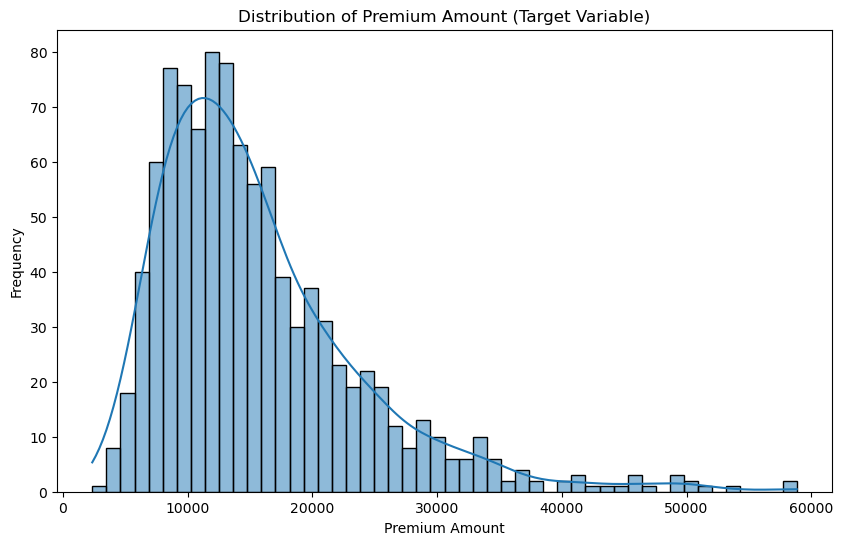

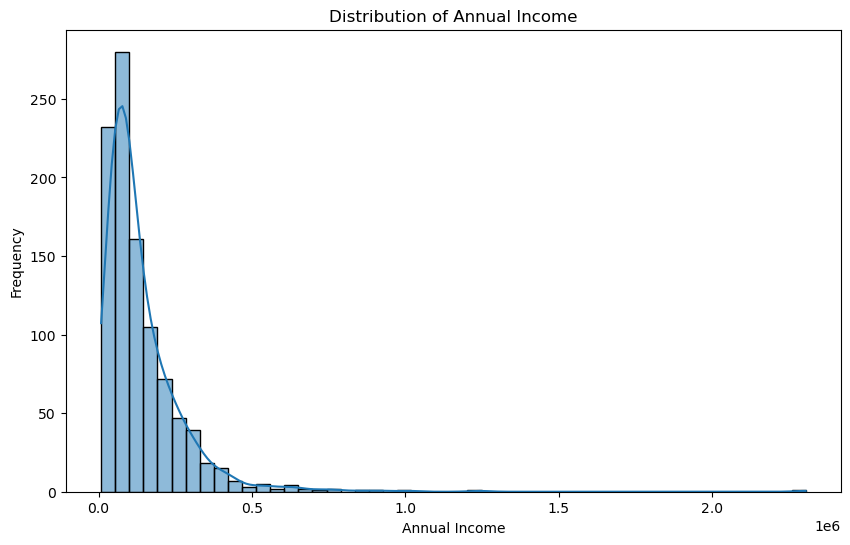

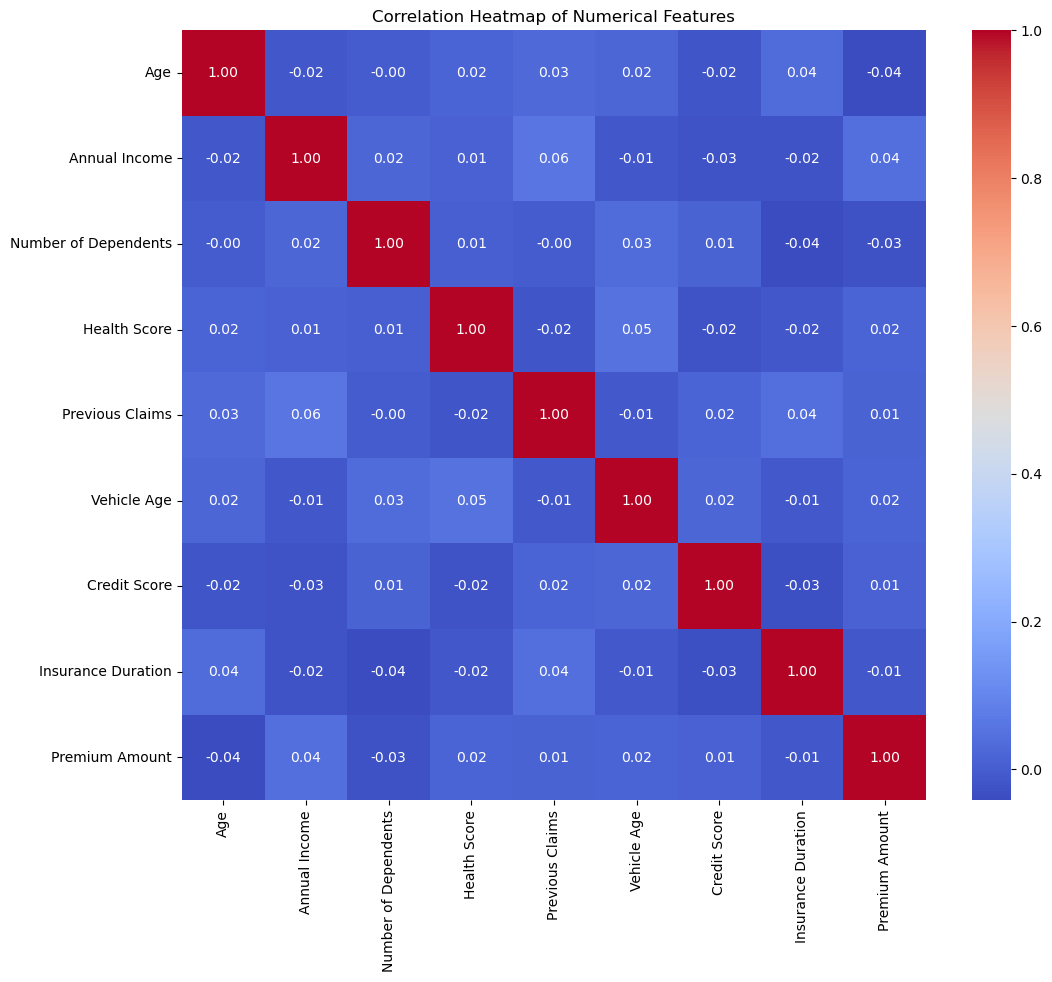

In [13]:
#Exploratory Data Analysis (EDA)

print("Missing Values Summary")
print(df.isnull().sum())

# Visualize the distribution of the target variable: Premium Amount
plt.figure(figsize=(10, 6))
sns.histplot(df['Premium Amount'], kde=True, bins=50)
plt.title('Distribution of Premium Amount (Target Variable)')
plt.xlabel('Premium Amount')
plt.ylabel('Frequency')
plt.show()

# Visualize a key skewed feature: Annual Income
plt.figure(figsize=(10, 6))
sns.histplot(df['Annual Income'], kde=True, bins=50)
plt.title('Distribution of Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Frequency')
plt.show()

# Display a correlation heatmap of numerical features
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [14]:
#Data Preprocessing Pipeline

# Defining which columns are for which type of categories
numeric_features = ['Age', 'Annual Income', 'Number of Dependents', 'Health Score',
                    'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']
categorical_features = ['Gender', 'Marital Status', 'Education Level', 'Occupation',
                        'Location', 'Policy Type', 'Smoking Status', 'Exercise Frequency',
                        'Property Type']
date_feature = 'Policy Start Date'
text_feature = 'Customer Feedback'

# Use  Income, Health Score and StandardScaler for others
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', RobustScaler()) 
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

# Creating a transformer for the date feature
def date_feature_engineer(X):
    X = pd.to_datetime(X['Policy Start Date'])
    X = pd.DataFrame({
        'Policy_Year': X.dt.year,
        'Policy_Month': X.dt.month,
        'Days_Since_Start': (datetime.date.today() - X.dt.date).astype('timedelta64[D]').astype(int)
    })
    return X.values 

date_transformer = Pipeline(steps=[
    ('date_extractor', FunctionTransformer(date_feature_engineer, validate=False))
])

# Create a transformer for the text feature : simple length
def text_feature_engineer(X):
    return pd.DataFrame(X['Customer Feedback'].str.len()).fillna(0).values

text_transformer = Pipeline(steps=[
    ('text_extractor', FunctionTransformer(text_feature_engineer, validate=False))
])

# Create the full preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ])

In [15]:
# Train-Test Split and Model Training

# Defining features (X) and target (y)
X = df.drop('Premium Amount', axis=1)
y = df['Premium Amount']

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Defining which test models to train
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=30, max_depth=10, random_state=RANDOM_STATE),
    'XGBoost': XGBRegressor(n_estimators=30, max_depth=5, learning_rate=0.1, random_state=RANDOM_STATE)
}

trained_models = {}

print("Training Models")
for name, model in models.items():
    print(f"Training {name}")
    
    # Creating a full pipeline with the preprocessor and the model
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    full_pipeline.fit(X_train, y_train)
    trained_models[name] = full_pipeline
    print(f"{name} training complete.")

Training set shape: (800, 19)
Testing set shape: (200, 19)
Training Models
Training Linear Regression
Linear Regression training complete.
Training Random Forest
Random Forest training complete.
Training XGBoost
XGBoost training complete.


In [16]:
#Model Evaluation

# Defining a function to compute evaluation of the metrics
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # RMSLE requires non-negative predictions, so we clip at 0
    rmsle = np.sqrt(np.mean(np.square(np.log1p(y_pred.clip(0)) - np.log1p(y_true))))
    return {'RMSE': rmse, 'MAE': mae, 'R2 Score': r2, 'RMSLE': rmsle}

evaluation_results = {}
best_model_name = None
best_rmse = float('inf')

print("\n--- Model Evaluation ---")
for name, pipeline in trained_models.items():
    y_pred = pipeline.predict(X_test)
    metrics = evaluate_model(y_test, y_pred)
    evaluation_results[name] = metrics
    
    print(f"\nModel: {name}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
        
    # Find the best model based on RMSE
    if metrics['RMSE'] < best_rmse:
        best_rmse = metrics['RMSE']
        best_model_name = name

# Displaying results in a DataFrame for easy comparison
results_df = pd.DataFrame(evaluation_results).T
print("\n--- Summary of Model Performance ---")
print(results_df)

print(f"The best performing model is: {best_model_name} (RMSE: {best_rmse:.4f})")


--- Model Evaluation ---

Model: Linear Regression
  RMSE: 8831.4051
  MAE: 6404.0100
  R2 Score: -0.0484
  RMSLE: 0.4854

Model: Random Forest
  RMSE: 9007.8793
  MAE: 6740.9091
  R2 Score: -0.0908
  RMSLE: 0.5024

Model: XGBoost
  RMSE: 8919.1031
  MAE: 6592.5428
  R2 Score: -0.0694
  RMSLE: 0.4926

--- Summary of Model Performance ---
                          RMSE          MAE  R2 Score     RMSLE
Linear Regression  8831.405124  6404.010000 -0.048435  0.485362
Random Forest      9007.879251  6740.909095 -0.090754  0.502364
XGBoost            8919.103124  6592.542803 -0.069361  0.492636
The best performing model is: Linear Regression (RMSE: 8831.4051)


In [17]:
#Save and Load Model

# Defining the file path for the best training model
model_filename = f'{best_model_name.replace(" ", "_")}_model.joblib'

# Save the best model using joblib
print(f"Saving the best model to '{model_filename}' ")
joblib.dump(trained_models[best_model_name], model_filename)
print("Model saved successfully.")

# Load the saved model to verify it works
print(f"Loading model from '{model_filename}' ")
loaded_model = joblib.load(model_filename)
print("Model loaded successfully.")

# Make a prediction with a new sample
sample_data = X_test.iloc[[0]] 
predicted_premium = loaded_model.predict(sample_data)[0]

print("\n--- Test Prediction with Loaded Model ---")
print(f"Sample data features: \n{sample_data}")
print(f"Actual Premium: ${y_test.iloc[0]:.2f}")
print(f"Predicted Premium: ${predicted_premium:.2f}")

Saving the best model to 'Linear_Regression_model.joblib' 
Model saved successfully.
Loading model from 'Linear_Regression_model.joblib' 
Model loaded successfully.

--- Test Prediction with Loaded Model ---
Sample data features: 
     Age  Gender  Annual Income Marital Status  Number of Dependents  \
521   32  Female         295042        Married                   NaN   

    Education Level  Occupation  Health Score Location Policy Type  \
521        Master's  Unemployed            13    Rural     Premium   

     Previous Claims  Vehicle Age  Credit Score  Insurance Duration  \
521                2            9           NaN                  10   

                Policy Start Date Customer Feedback Smoking Status  \
521 2016-10-11 15:54:14.054054080    Very satisfied            Yes   

    Exercise Frequency Property Type  
521              Daily         Condo  
Actual Premium: $9848.00
Predicted Premium: $16004.00


In [18]:
#MLflow Integration 

print("MLflow Experiment Tracking")
print("Tracking experiments locally in the './mlruns' folder.")

for name, pipeline in trained_models.items():
    with mlflow.start_run(run_name=f'{name}_run'):
        
        mlflow.log_param('model_name', name)
        
      
        if name == 'Random Forest':
            mlflow.log_param('n_estimators', pipeline.named_steps['regressor'].n_estimators)
            mlflow.log_param('max_depth', pipeline.named_steps['regressor'].max_depth)

        # here we Make predictions and log metrics
        y_pred = pipeline.predict(X_test)
        metrics = evaluate_model(y_test, y_pred)
        mlflow.log_metrics(metrics)
        
        # Log the trained model as an artifact
        mlflow.sklearn.log_model(
            sk_model=pipeline,
            artifact_path="model",
            registered_model_name=f"{name}_Model"
        )
        print(f"MLflow run logged for {name}")

print("To view the results, navigate to the directory of this notebook and run 'mlflow ui' in your terminal.")

MLflow Experiment Tracking
Tracking experiments locally in the './mlruns' folder.


2025/08/26 17:07:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/26 17:07:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Linear Regression_Model' already exists. Creating a new version of this model...
Created version '3' of model 'Linear Regression_Model'.
2025/08/26 17:07:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MLflow run logged for Linear Regression


2025/08/26 17:08:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Random Forest_Model' already exists. Creating a new version of this model...
Created version '3' of model 'Random Forest_Model'.
2025/08/26 17:08:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MLflow run logged for Random Forest


2025/08/26 17:08:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'XGBoost_Model' already exists. Creating a new version of this model...
Created version '3' of model 'XGBoost_Model'.


MLflow run logged for XGBoost
To view the results, navigate to the directory of this notebook and run 'mlflow ui' in your terminal.
